## ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


In [2]:
# Load the labeled data
good_examples = pd.read_csv('./InDaS Labeled/good_period_2024_01_03.csv')
good_examples

bad_examples = pd.read_csv('./InDaS Labeled/bad_period_2024_01_06.csv')
bad_examples

all_good_segments = []
all_bad_segments = []

In [3]:
# Apply the indicator function to create a new column
good_examples['indicator'] = good_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_good = good_examples.index[good_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_good.append(len(good_examples))


# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_good)-1):
    good_segment = good_examples.iloc[start_indices_good[i]:start_indices_good[i + 1]]
    all_good_segments.append(good_segment)

print("Total Good Cutting Data:", len(all_good_segments))
print("Shape of Segment 1:", all_good_segments[0].shape)
print("Shape of Torque Data:", all_good_segments[0]['Torque'].shape)


Total Good Cutting Data: 4552
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


In [4]:
# Apply the indicator function to create a new column
bad_examples['indicator'] = bad_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_bad = bad_examples.index[bad_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_bad.append(len(bad_examples))

# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_bad)-1):
    segment = bad_examples.iloc[start_indices_bad[i]:start_indices_bad[i + 1]]
    all_bad_segments.append(segment)

print("Total Bad Cutting Data:", len(all_bad_segments))
print("Shape of Segment 1:", all_bad_segments[0].shape)
print("Shape of Torque Data:", all_bad_segments[0]['Torque'].shape)


Total Bad Cutting Data: 1937
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


## Convert Time-Series into Spectogram Features

### Mel's Spectogram Features

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1668
  warnings.warn(
/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1667
  warnings.warn(


(256, 53)


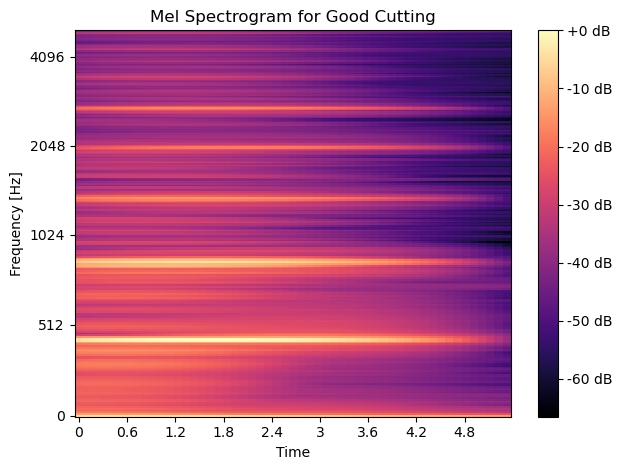

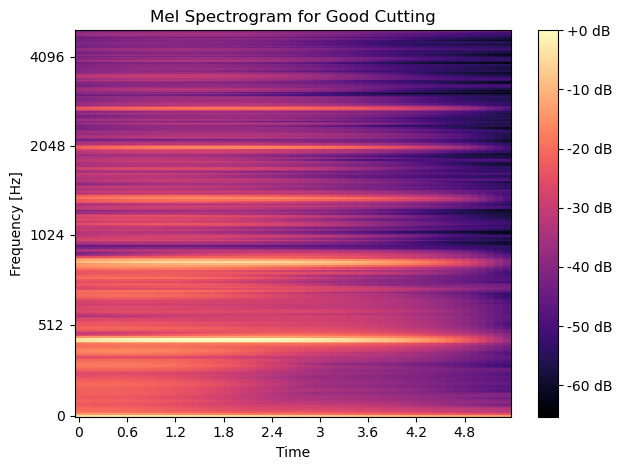

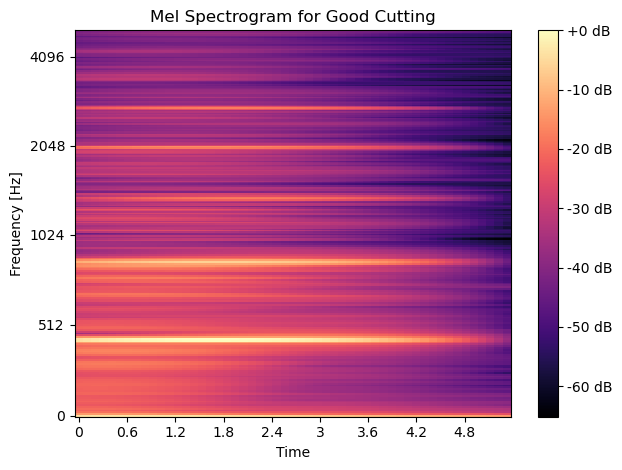

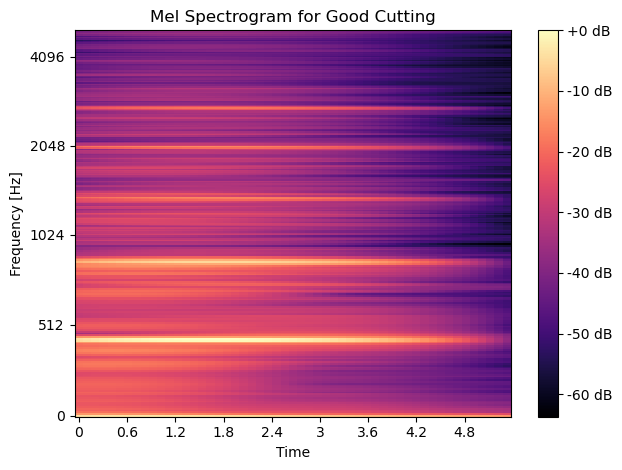

In [23]:
import librosa
import librosa.display
import random

MAX_SAMPLES_GOOD = 4552
MAX_SAMPLES_BAD = 1937

#MAX_SAMPLES_GOOD = 4
#MAX_SAMPLES_BAD = 4

good_mels_features = []
bad_mels_features = []
# Function to compute and plot Mel spectrogram
def compute_mel_spectrogram(data, sample_rate=5000, n_mels=256, fmax=None, hop_length=32):
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=n_mels, fmax=fmax, hop_length=hop_length)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

for i in range(MAX_SAMPLES_GOOD):
    good_cutting_mels = np.asarray(all_good_segments[i]['Torque'])
    good_mels = compute_mel_spectrogram(good_cutting_mels)
    good_mels_features.append(good_mels)


for i in range(MAX_SAMPLES_BAD):
    bad_cutting_mels = np.asarray(all_bad_segments[i]['Torque'])
    bad_mels = compute_mel_spectrogram(bad_cutting_mels)
    bad_mels_features.append(bad_mels)

print(good_mels.shape)

# Plot
'''for m in good_mels_features:
    fig = plt.figure()
    librosa.display.specshow(m, x_axis='time', y_axis='mel', sr=5000, fmax=5000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram for Good Cutting')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
    fig.savefig(f'/home/admin-anedunga/Desktop/InDas_Template/figures and graphs/good_cutting_mels{random.randint(1, 9)}.png', dpi=fig.dpi)'''

## Undersample Classes to Balance Them

### Mel's Features

In [6]:
SAMPLES_FOR_TRAINING = 1800
balanced_good_mel_features = np.array(good_mels_features[:SAMPLES_FOR_TRAINING])
balanced_bad_mel_features = np.array(bad_mels_features[:SAMPLES_FOR_TRAINING])

validation_good_mel_features = np.array(good_mels_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_GOOD])
validation_bad_mel_features = np.array(bad_mels_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_BAD])

validation_good_mel_labels = np.ones(validation_good_mel_features.shape[0])
validation_bad_mel_labels = np.zeros(validation_bad_mel_features.shape[0])

validation_mel_features = np.concatenate((validation_good_mel_features, validation_bad_mel_features), axis=0)
validation_mel_labels = np.concatenate((validation_good_mel_labels, validation_bad_mel_labels), axis=0)
print("Mel Features Val Shape:", validation_mel_features.shape)
print("Balanced_Good", balanced_good_mel_features.shape)
print("Balanced_Bad", balanced_bad_mel_features.shape)

Mel Features Val Shape: (0,)
Balanced_Good (3, 128, 27)
Balanced_Bad (3, 128, 27)


### Data Augmentation for Mel's Features using Mixup

In [7]:
# # Code copied and edited from https://www.kaggle.com/code/kaerunantoka/birdclef2022-use-2nd-label-f0
# def mixup(original_melspecs, original_labels, alpha=1.0):
#     indices = torch.randperm(original_melspecs.size(0))

#     lam = np.random.beta(alpha, alpha)

#     augmented_melspecs = original_melspecs * lam + original_melspecs[indices] * (1 - lam)
#     augmented_labels = [(original_labels * lam), (original_labels[indices] * (1 - lam))]

#     return augmented_melspecs, augmented_labels

### Per Channel Energy Normalization Tryout

In [8]:
# S = librosa.feature.melspectrogram(y=y, sr=sr)
# S_pcen = librosa.pcen(S)
#librosa.pcen(S, *, sr=22050, hop_length=512, gain=0.98, bias=2, power=0.5, time_constant=0.4, eps=1e-06, b=None, max_size=1, ref=None, axis=-1, max_axis=None, zi=None, return_zf=False)
#IMPORTANT: the default values of eps, gain, bias, and power match the original publication, in which S is a 40-band mel-frequency spectrogram with 25 ms windowing, 
# 10 ms frame shift, and raw audio values in the interval [-2**31; 2**31-1[. 
# If you use these default values, we recommend to make sure that the raw audio is properly scaled to this interval, and not to [-1, 1[ as is most often the case.


# Alternate to Mel Spectogram Computation
# def wav2melspec(fp):
#     y, sr = librosa.load(fp)
#     S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
#     log_S = librosa.amplitude_to_db(S, ref=np.max)
#     img = librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
#     # get current figure without white border
#     img = plt.gcf()
#     img.gca().xaxis.set_major_locator(plt.NullLocator())
#     img.gca().yaxis.set_major_locator(plt.NullLocator())
#     img.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
#             hspace = 0, wspace = 0)
#     img.gca().xaxis.set_major_locator(plt.NullLocator())
#     img.gca().yaxis.set_major_locator(plt.NullLocator())
#     # to pil image
#     img.canvas.draw()
#     img = Image.frombytes('RGB', img.canvas.get_width_height(), img.canvas.tostring_rgb())
#     return img

## Dataloader

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Create labels for the features
good_labels = [1] * len(balanced_good_mel_features)  # Label 1 for good torque
bad_labels = [0] * len(balanced_bad_mel_features)    # Label 0 for bad torque

# Combine features and labels
features = np.array(balanced_good_mel_features + balanced_bad_mel_features)
labels = np.array(good_labels + bad_labels)

# Custom Dataset class
class MelSpectrogramDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create dataset and dataloaders
dataset = MelSpectrogramDataset(features, labels)
train_size = int(0.6 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_dataset = MelSpectrogramDataset(validation_mel_features, validation_mel_labels)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


ValueError: num_samples should be a positive integer value, but got num_samples=0

## Training ResNet 18 CNN Classifier

/tmp/ipykernel_204928/1035571402.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1/6, Train Loss: 0.4703
Epoch 2/6, Train Loss: 0.1322
Epoch 3/6, Train Loss: 0.0619
Epoch 4/6, Train Loss: 0.0394
Epoch 5/6, Train Loss: 0.0282
Epoch 6/6, Train Loss: 0.0222
Test Accuracy: 100.00%


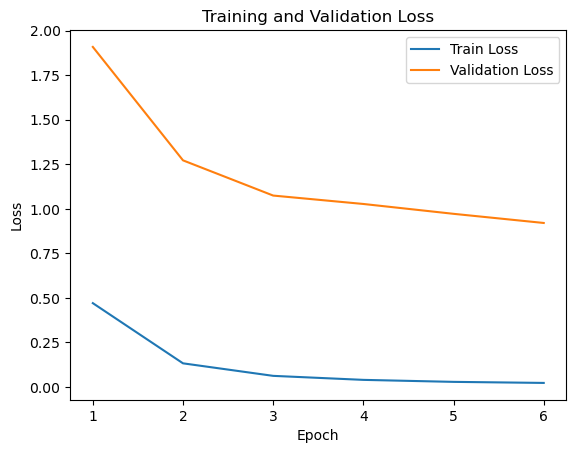

In [ ]:

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Modify ResNet-18
class ResNet18MelSpectrogram(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18MelSpectrogram, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer before the fully connected layer
            nn.Linear(self.resnet.fc.in_features, 2)  # 2 classes: good and bad
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

# Instantiate model, loss function, and optimizer
model = ResNet18MelSpectrogram(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Training loop
num_epochs = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loss = []  # List to store training loss for each epoch
val_loss = []  # List to store validation loss for each epoch (if available)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / train_size
    train_loss.append(epoch_loss)  # Append training loss to the list

    # Add validation loss calculation here (if you have validation data)
    if val_loader:  # Check if validation loader exists
        model.eval()
        with torch.no_grad():
            val_epoch_loss = 0.0
            for inputs, labels in val_loader:
                inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item() * inputs.size(0)
            val_epoch_loss /= test_size  # Calculate average validation loss
            val_loss.append(val_epoch_loss)  # Append validation loss to the list

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')


# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Plotting training and validation loss (if available)
if val_loss:  # Check if validation loss data exists
    plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("Validation data not found. Training loss plotted only.")
    plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

### Validation

In [ ]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Correct Preditions/Total", correct, "/", total)
print(f'Validation Accuracy: {accuracy:.2f}%')

/tmp/ipykernel_204928/1035571402.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Correct Preditions/Total 2752 / 2889
Validation Accuracy: 95.26%


## Save Model

In [ ]:
# if accuracy > 95:
#      torch.save(model.state_dict(),f'Mel-model_ResNet18__98.62_10ep{accuracy:.2f}.pth')
#      print("Model Saved")

## LeNet CNN Classifier

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        
        # Calculate the size of the feature maps before the first fully connected layer
        self.fc_input_size = 120 * 32 * 6  # This is based on the new input size and conv layers
        
        self.linear1 = nn.Linear(self.fc_input_size, 84)
        self.linear2 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))  # Output: [batch_size, 120, 32, 6]
        x = x.view(x.size(0), -1)  # Flatten: [batch_size, 120 * 32 * 6]
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
Lenet = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Lenet.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
num_epochs = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(inputs.shape)
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
        #print(inputs.shape)
        # zero the parameter gradients
        optimizer.zero_grad() 

        # forward + backward + optimize
        outputs = Lenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
# Validation
Lenet.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
        outputs = Lenet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Correct Preditions/Total", correct, "/", total)
print(f'Validation Accuracy: {accuracy:.2f}%')

/tmp/ipykernel_204928/1035571402.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Correct Preditions/Total 2752 / 2889
Validation Accuracy: 95.26%


## Custom 3 Layer CNN

In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(3 * 3 * 64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out